In [87]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the data in training_dictionary.txt
with open("training_dictionary.txt", "r") as file:
    words = file.read().splitlines()

In [6]:
print(len(words))
words[:10]

117188


['intermammary',
 'suprarationalism',
 'overdeliberation',
 'colliquativeness',
 'stemona',
 'uricaemic',
 'epitrichial',
 'poniard',
 'undye',
 'unscathedly']

In [7]:
len("".join(words))

1123780

In [38]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

thyroparathyroidectomize 24


In [43]:
vocab = set("".join(words))
vocab = [".", "_"] + list(vocab)
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

29
{'.': 0, '_': 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
{0: '.', 1: '_', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [54]:
# create a dataset where each character is masked with an underscore
block_size = 8
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    if len(word) < block_size:
        word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:100]

361605


['intermam',
 'ntermamm',
 'termamma',
 'ermammar',
 'rmammary',
 'suprarat',
 'uprarati',
 'praratio',
 'raration',
 'arationa',
 'rational',
 'ationali',
 'tionalis',
 'ionalism',
 'overdeli',
 'verdelib',
 'erdelibe',
 'rdeliber',
 'delibera',
 'eliberat',
 'liberati',
 'iberatio',
 'beration',
 'colliqua',
 'olliquat',
 'lliquati',
 'liquativ',
 'iquative',
 'quativen',
 'uativene',
 'ativenes',
 'tiveness',
 'stemona.',
 'uricaemi',
 'ricaemic',
 'epitrich',
 'pitrichi',
 'itrichia',
 'trichial',
 'poniard.',
 'undye...',
 'unscathe',
 'nscathed',
 'scathedl',
 'cathedly',
 'calcaneo',
 'alcaneof',
 'lcaneofi',
 'caneofib',
 'aneofibu',
 'neofibul',
 'eofibula',
 'ofibular',
 'realiena',
 'ealienat',
 'alienate',
 'hypoid..',
 'constabu',
 'onstabul',
 'nstabula',
 'stabular',
 'tabulary',
 'retrorec',
 'etrorece',
 'trorecep',
 'rorecept',
 'orecepti',
 'receptio',
 'eception',
 'kraal...',
 'chemurgi',
 'hemurgic',
 'petrophi',
 'etrophil',
 'trophilo',
 'rophilou',
 'ophilous',

In [63]:
dataset = []
for word in truncated_words:
    for i in range(len(word)):
        if word[i] == ".":
            continue
        dataset.append((word[:i] + "_" + word[i + 1 :], word[i]))

# print the first 10 elements of the dataset
print(dataset[:10])

[('_ntermam', 'i'), ('i_termam', 'n'), ('in_ermam', 't'), ('int_rmam', 'e'), ('inte_mam', 'r'), ('inter_am', 'm'), ('interm_m', 'a'), ('interma_', 'm'), ('_termamm', 'n'), ('n_ermamm', 't')]


In [66]:
# convert the words to a list of ints
integerized_dataset = []
for word, label in dataset:
    integerized_dataset.append(([stoi[char] for char in word], stoi[label]))

print(integerized_dataset[:1])

[([1, 16, 22, 7, 20, 15, 3, 15], 11)]


In [77]:
# create a pytorch dataset of word and label pairs
from torch.utils.data import Dataset
import random


class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


split_idx = int(len(integerized_dataset) * 0.9)
shuffled_integerized_dataset = list(integerized_dataset)
random.shuffle(shuffled_integerized_dataset)
train_split = shuffled_integerized_dataset[:split_idx]
val_split = shuffled_integerized_dataset[split_idx:]

train_dataset = HangmanDataset(train_split)
val_dataset = HangmanDataset(val_split)

print(train_dataset[[0, 1, 2]])
print(val_dataset[[0, 1, 2]])

(tensor([[16, 17,  1, 10, 27, 16,  5, 10],
        [ 4,  7, 14,  1,  3, 20, 11,  3],
        [ 5, 11, 24, 11,  5,  3, 14,  1]]), tensor([20, 14, 14]))
(tensor([[ 5, 17,  1, 15, 17, 22, 10,  7],
        [16, 22,  1, 20, 22,  3, 11, 16],
        [21, 18, 20, 11,  1, 13, 14,  7]]), tensor([21,  7, 16]))


Epoch 1/10


Loss: 1.6661:   2%|▏         | 49/2492 [00:08<07:11,  5.66it/s]


Epoch 2/10


Loss: 1.3384:   2%|▏         | 49/2492 [00:08<07:02,  5.78it/s]


Epoch 3/10


Loss: 1.1762:   2%|▏         | 49/2492 [00:08<07:04,  5.76it/s]


Epoch 4/10


Loss: 1.0032:   2%|▏         | 49/2492 [00:08<07:20,  5.54it/s]


Epoch 5/10


Loss: 1.0977:   2%|▏         | 49/2492 [00:08<07:07,  5.72it/s]


Epoch 6/10


Loss: 0.8882:   2%|▏         | 49/2492 [00:08<07:09,  5.69it/s]


Epoch 7/10


Loss: 0.7336:   2%|▏         | 49/2492 [00:08<07:15,  5.61it/s]


Epoch 8/10


Loss: 0.7930:   2%|▏         | 49/2492 [00:08<07:24,  5.50it/s]


Epoch 9/10


Loss: 1.1737:   2%|▏         | 49/2492 [00:08<07:19,  5.55it/s]


Epoch 10/10


Loss: 0.5245:   2%|▏         | 49/2492 [00:09<07:36,  5.36it/s]


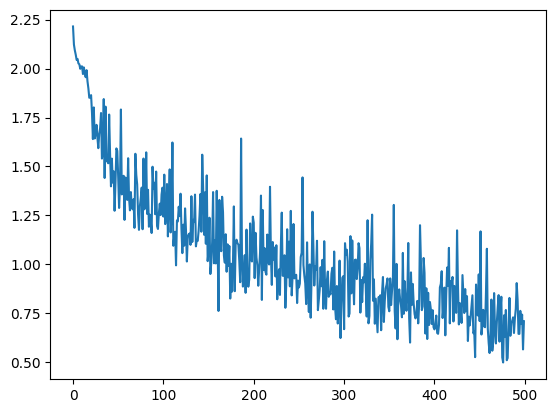

In [97]:
# Create a transformer model for the hangman game

import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

d_model = 128
nhead = 1
num_layers = 1


class HangmanTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0.1):
        super(HangmanTransformer, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout

        # Create positional encoding matrix
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Create positional encoding class
        class PositionalEncoding(nn.Module):
            def __init__(self, d_model, dropout=0.1, max_len=5000):
                super().__init__()
                self.dropout = nn.Dropout(p=dropout)

                # Create positional encoding matrix
                pe = torch.zeros(max_len, d_model)
                position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
                div_term = torch.exp(
                    torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
                )
                pe[:, 0::2] = torch.sin(position * div_term)
                pe[:, 1::2] = torch.cos(position * div_term)
                pe = pe.unsqueeze(0)
                self.register_buffer("pe", pe)

            def forward(self, x):
                x = x + self.pe[:, : x.size(1)]
                return self.dropout(x)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        logits = self.fc(output)
        return logits


# create a transformer model
model = HangmanTransformer(vocab_size, d_model, nhead, num_layers)

# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model
batch_size = 1024
num_epochs = 10

lossi = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        features, labels = train_dataset[i : i + batch_size]
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(features)

        # Calculate loss
        loss = criterion(
            logits, torch.nn.functional.one_hot(labels, num_classes=vocab_size)
        )

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if i % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")
        lossi.append(loss.item())
        if i > 50000:
            break

plt.plot(lossi)
plt.show()

In [98]:
model.eval()
with torch.no_grad():
    for i in (pbar := tqdm(range(0, len(val_dataset), batch_size))):
        features, labels = val_dataset[i : i + batch_size]
        logits = model(features)
        loss = criterion(
            logits, torch.nn.functional.one_hot(labels, num_classes=vocab_size)
        )
    print(loss)

  0%|          | 0/277 [00:00<?, ?it/s]